# CSCE 479/879 Hackathon: Reinforcement Learning and PPO

Written by Eleanor Quint

Modified by Mrinal Rawool and Stephen Scott

Topics:
- Reinforcement Learning
- Proximal Policy Optimization

This is all setup in a IPython notebook so you can run any code you want to experiment with. Feel free to edit any cell, or add some to run your own code.

Future developement of the package 'gym' has been moved to 'gymnasium'. 

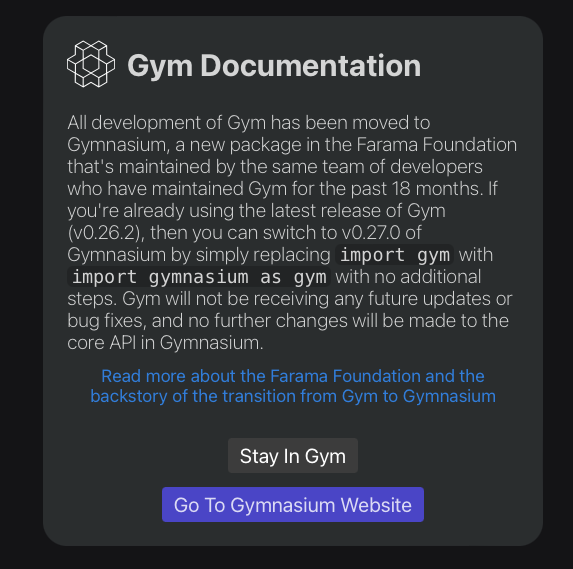

Please refer the below link for more information
https://gymnasium.farama.org/environments/classic_control/cart_pole/

This notebook uses gymnasium and works with the shared conda environment.

In [1]:
# We'll start with our library imports...
from __future__ import print_function

import numpy as np                 # to use numpy arrays
import tensorflow as tf            # to specify and run computation graphs
import tensorflow_datasets as tfds # to load training data
import matplotlib.pyplot as plt    # to visualize data and draw plots
from tqdm import tqdm              # to track progress of loops
import gymnasium as gym            # to setup and run RL environments import gym
# import gym
import scipy.signal                # for a specific convolution function

### Reinforcement Learning

Rather than training a deep model to classify, we're going to try to teach one how to act optimally in an environment. Thus, rather than training with a particular dataset, we're going to create an environment with which to interact. The model will take in the environment state and choose an action to take. We want to train the model to choose the best action in any given state.

We'll use OpenAI Gym to create and run the environment we'll be interacting with. The default here is [Cart Pole](https://gymnasium.farama.org/environments/classic_control/cart_pole/), but feel free to look at and experiment with others.

In [2]:
env = gym.make('CartPole-v1')
NUM_ACTIONS = env.action_space.n
OBS_SHAPE = env.observation_space.shape

#### env.action_space

The action is a ndarray with shape (1,) which can take values {0, 1} indicating the direction of the fixed force the cart is pushed with.

0: Push cart to the left
1: Push cart to the right
Note: The velocity that is reduced or increased by the applied force is not fixed and it depends on the angle the pole is pointing. The center of gravity of the pole varies the amount of energy needed to move the cart underneath it

In [3]:
NUM_ACTIONS

2

#### env.observation_space

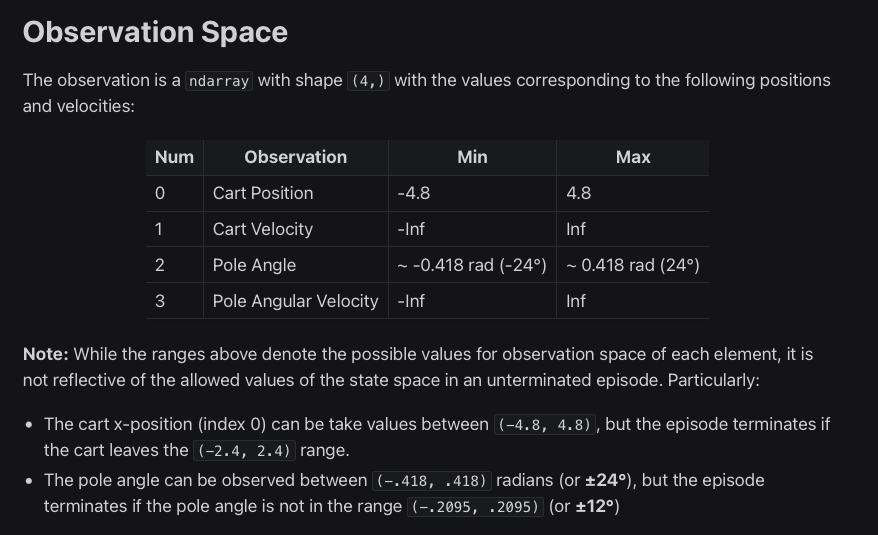

In [4]:
OBS_SHAPE

(4,)

We're going to use an approach to optimization called "policy iteration". This is where we
1. instantiate a random policy (parameterized by a deep neural network) and
2.  optimize it in steps.

The basic algorithm in this approach is called "REINFORCE".

In each step we'll collect experiences from the environment for one episode (e.g., in Cart Pole, from the initial state of the simulation until the pole falls too far).

After the episode we'll calculate how well the policy did and update it to perform better next time.


#### Actor-critic algorithms
The family of algorithms we're going to use is a type of policy iteration called "Actor-critic". So called because we're going to create an actor network (the policy) and a critic (the value network).

The actor will take some actions in the environment and the critic will evaluate a baseline for how good those actions should be.

If the actions turn out better than the baseline, the actions are reinforced. Otherwise, if the actions are worse than expected, they are reduced in probability.

Here is a flowchart explaining the process of collecting experiences:

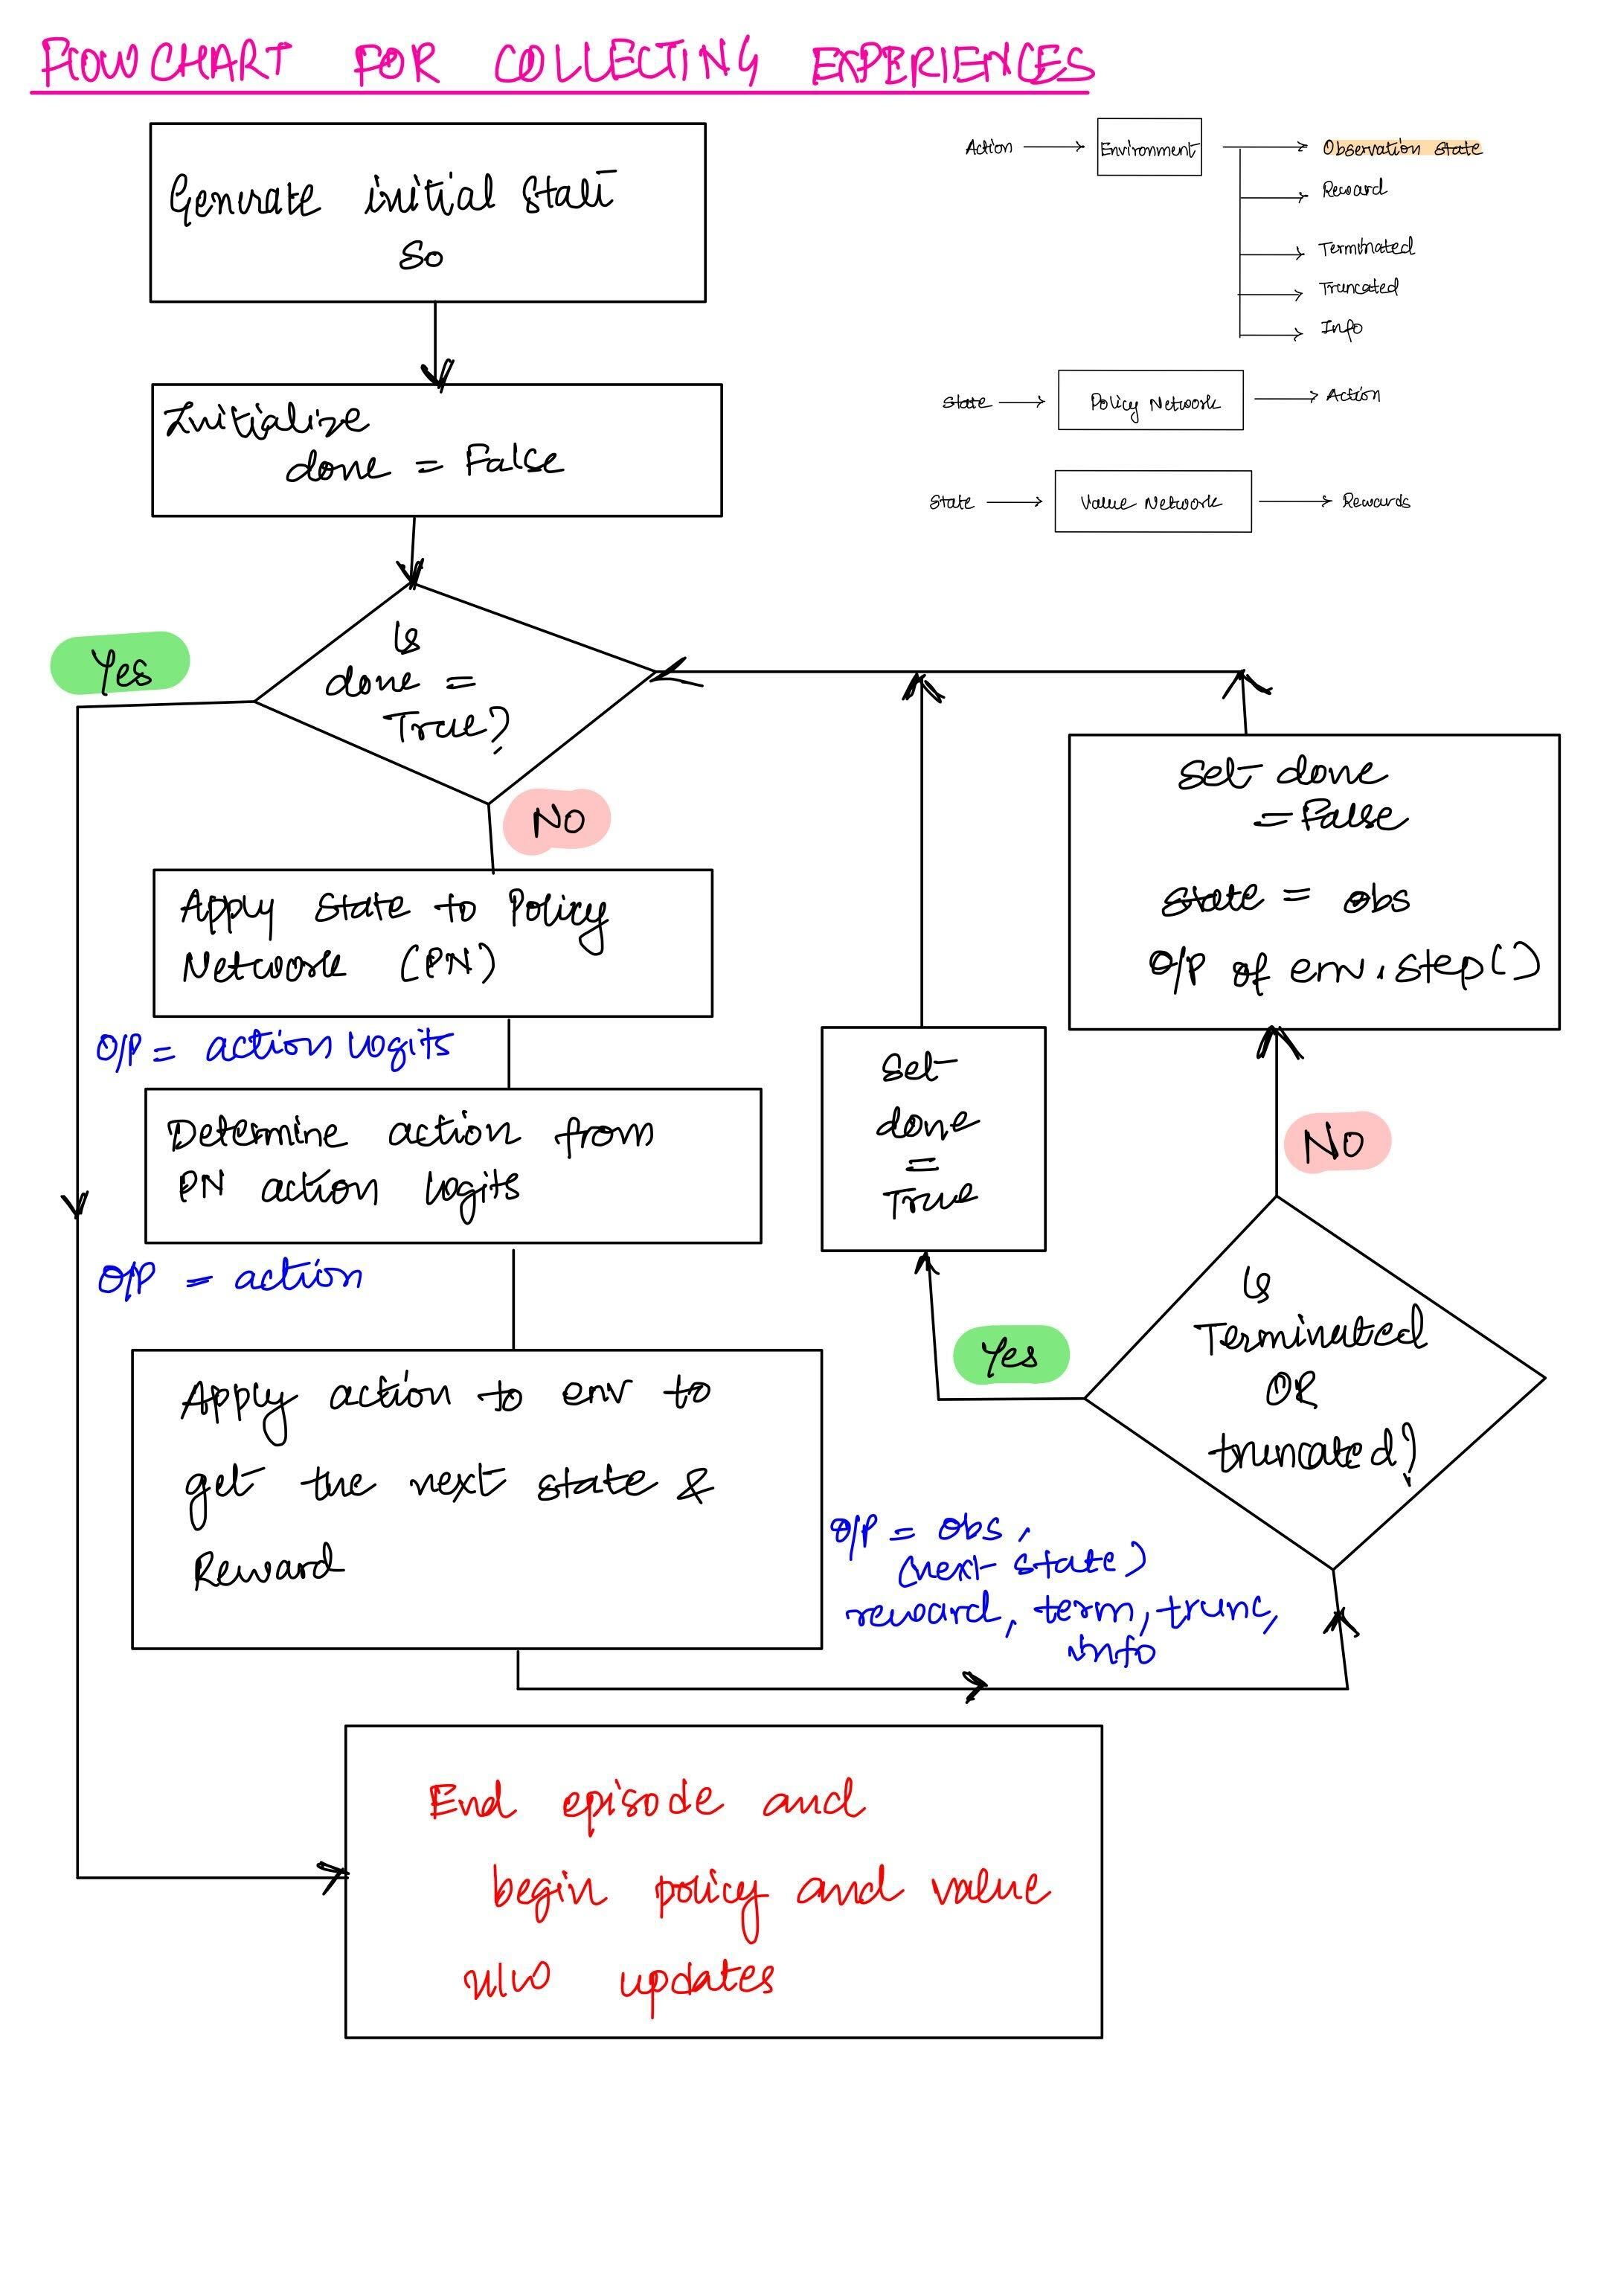

In [5]:
network_fn = lambda shape: tf.keras.Sequential([
                            tf.keras.layers.Dense(256, activation=tf.nn.tanh),
                            tf.keras.layers.Dense(256, activation=tf.nn.tanh),
                            tf.keras.layers.Dense(shape)])


In [6]:
# We'll declare our two networks
policy_network = network_fn(NUM_ACTIONS) # what is the next action going to be
value_network = network_fn(1) # the value generated by the action

2024-04-17 13:14:08.372954: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-17 13:14:10.105736: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30979 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:5e:00.0, compute capability: 7.0


In [7]:
# Reset the environment to start a new episode
state = env.reset()

In [8]:
state # shape = obs shape

(array([-0.04759745,  0.00309694, -0.01017296,  0.02122471], dtype=float32),
 {})

In [9]:
#gymnasium
input_ = np.expand_dims(state[0], 0)
input_.shape

(1, 4)

In [10]:
# Evaluate the first state
policy_action_logits = policy_network(input_)
est_value = value_network(input_)
print("Policy action logits:", policy_action_logits)
print("Estimated Value:", est_value)

Policy action logits: tf.Tensor([[-0.00556866 -0.00674769]], shape=(1, 2), dtype=float32)
Estimated Value: tf.Tensor([[-0.00699837]], shape=(1, 1), dtype=float32)


In [11]:
print(tf.nn.softmax(policy_action_logits))
print(tf.nn.log_softmax(policy_action_logits)) # better at handling extreme values

tf.Tensor([[0.50029474 0.49970523]], shape=(1, 2), dtype=float32)
tf.Tensor([[-0.6925579 -0.6937369]], shape=(1, 2), dtype=float32)


### Proximal Policy Optimization (PPO)

More specifically, we're going to use an algorithm called "Proximal Policy Optimization".

The key element this algorithm adds to the actor-critic family of algorithms is a **limit to how much it can change the policy in one round of training**.

This ensures that the policy remains **stable** and gets better more or less monotonically.

We use KL divergence as a mechanism to limit the change between the distribution over actions before and after training.

In [12]:
VALUE_FN_ITERS = 80
POLICY_FN_ITERS = 80
KL_MARGIN = 1.2
KL_TARGET = 0.01
CLIP_RATIO = 0.2

# optimizer = tf.keras.optimizers.legacy.Adam() # colab
optimizer = tf.keras.optimizers.Adam()

def discount_cumsum(x, discount):
    """
    magic from the rllab library for computing discounted cumulative sums of vectors.
    input:
        vector x,
        [x0,
         x1,
         x2]
    output:
        [x0 + discount * x1 + discount^2 * x2,
         x1 + discount * x2,
         x2]
    """
    return scipy.signal.lfilter([1], [1, float(-discount)], x[::-1],
                                axis=0)[::-1]

def categorical_kl(logp0, logp1):
    """Returns average kl divergence between two batches of distributions"""
    all_kls = tf.reduce_sum(tf.exp(logp1) * (logp1 - logp0), axis=1)
    return tf.reduce_mean(all_kls)

def update_fn(policy_network, value_network, states, actions, rewards, gamma=0.99):
    # Calculate the difference between how the actor did and how the critic expected it to do
    # We call this difference, "advantage"
    vals = np.squeeze(value_network(states))
    deltas = rewards[:-1] + gamma * vals[1:] - vals[:-1]
    advantage = discount_cumsum(deltas, gamma)

    # Calculate the action probabilities before any updates
    action_logits = policy_network(states)
    initial_all_logp = tf.nn.log_softmax(action_logits)
    row_indices = tf.range(initial_all_logp.shape[0])
    indices = tf.transpose([row_indices, actions])
    initial_action_logp = tf.gather_nd(initial_all_logp, indices)

    # policy loss
    # Training objective:  we want to increase the probabilities of actions that lead to higher advantages.
    for _ in range(POLICY_FN_ITERS):
        with tf.GradientTape() as tape:
            # get the policy's action probabilities
            action_logits = policy_network(states)
            all_logp = tf.nn.log_softmax(action_logits)

            row_indices = tf.range(all_logp.shape[0])
            indices = tf.transpose([row_indices, actions])
            action_logp = tf.gather_nd(all_logp, indices)

            # decide how much to reinforce
            ratio = tf.exp(action_logp - tf.stop_gradient(initial_action_logp))
            min_adv = tf.where(advantage > 0.,
                               tf.cast((1.+CLIP_RATIO)*advantage, tf.float32),
                               tf.cast((1.-CLIP_RATIO)*advantage, tf.float32)
                               )
            surr_adv = tf.reduce_mean(tf.minimum(ratio[:-1] * advantage, min_adv))
            pi_objective = surr_adv
            pi_loss = -1. * pi_objective

        # update policy
        grads = tape.gradient(pi_loss, policy_network.trainable_variables)
        optimizer.apply_gradients(zip(grads, policy_network.trainable_variables))

        # figure out how much the policy has changed for early stopping
        kl = categorical_kl(all_logp, initial_all_logp)
        if kl > KL_MARGIN * KL_TARGET:
            break

    # value loss
    # supervised training for a fixed number of iterations
    # we want to reduce the difference between the observed rewards and the predicted values
    returns = discount_cumsum(rewards, gamma)[:-1]
    for _ in range(VALUE_FN_ITERS):
        with tf.GradientTape() as tape:
            vals = value_network(states)[:-1]
            val_loss = (vals - returns)**2
        # update value function
        grads = tape.gradient(val_loss, value_network.trainable_variables)
        optimizer.apply_gradients(zip(grads, value_network.trainable_variables))

Now we'll put this together with collecting experiences in the environment. Below is code for training the policy for one episode. It will choose actions randomly according to the probabilities chosen by the policy network and then, once the episode is done, it will train using those experiences.

In [13]:
### CODE FOR 1 EPISODE OF TRAINING
state_buffer = []
action_buffer = []
reward_buffer = []

done = False
state = env.reset()
episode_len = 0
# Collect experiences from a one episode rollout
while not done:
    # store the initial state (and every state thereafter)
    curr_state = state[0]
    state_buffer.append(curr_state) # gymnasium: numpy to tensor conversion error

    # choose action
    action_logits = policy_network(np.expand_dims(state[0], 0)) # gymnasium: numpy to tensor conversion error
    action = np.squeeze(tf.random.categorical(action_logits, 1))
    action_buffer.append(action)

    # step environment
    obs, reward, terminated, truncated , info = env.step(action) # gymnasium
    reward_buffer.append(reward)

    episode_len+=1
    
    if (terminated or truncated): # gymnasium
        done=True
    else:
        done=False
        curr_state = obs


# Run training update
states = np.stack(state_buffer)
actions = np.array(action_buffer)
rewards = np.array(reward_buffer)
update_fn(policy_network, value_network, states, actions, rewards)

In [14]:
episode_len

27

### Homework

Write code to extend training to multiple episodes. Then, plot the mean entropy of the action distribution using the following function over the course of 25 episodes as well as the length of each episode. If the agent works well, the episodes should get longer. RL can be very random, so don't be surprised if you get a very good or bad outcome in your first try.

In [15]:
def categorical_entropy(logits):
    return -1 * tf.reduce_mean(tf.reduce_sum(tf.nn.softmax(logits) * tf.nn.log_softmax(logits), axis=-1))

### Trial